### Import Dependencies

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout

import librosa          #Read, write, play around with audio files
import librosa.display

import numpy as np
import pandas as pd
import random

import warnings
warnings.filterwarnings('ignore')

### Load Dataset

In [5]:
df = pd.read_csv('UrbanSound8K.csv')

In [7]:
df.sample(5)

,slice_file_name,fsID,start,end,salience,fold,classID,class
707,113202-5-0-25.wav,113202,12.500000,16.500000,1,8,5,engine_idling
2933,162134-7-15-4.wav,162134,263.597486,267.597486,1,10,7,jackhammer
5967,29721-4-0-10.wav,29721,5.000000,9.000000,1,3,4,drilling
3364,169044-2-0-5.wav,169044,2.500000,6.500000,1,3,2,children_playing
862,11722-3-0-0.wav,11722,0.087343,1.345883,1,10,3,dog_bark


In [9]:
df.shape

(8732, 8)

### Work on Data

#### Get valid data

In [15]:
# Consider data above 3s
valid_data = df[['slice_file_name','fold','classID','class']][df['end']-df['start'] >= 3]

In [17]:
valid_data.shape

(7468, 4)

#### Create a Spectogram

In [20]:
y, sr = librosa.load('fold6/135160-8-0-0.wav', duration = 2.97)
ps = librosa.feature.melspectrogram(y = y, sr = sr)
ps.shape

(128, 128)

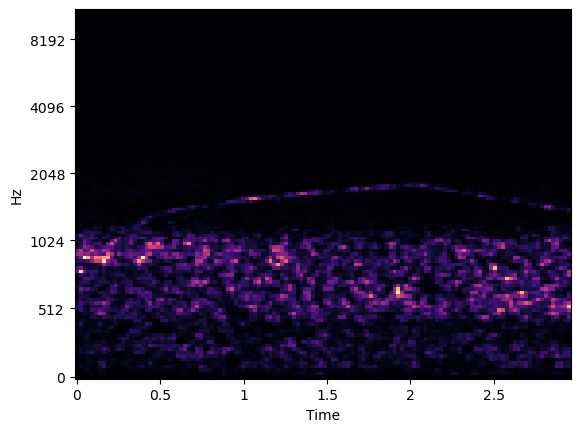

In [21]:
librosa.display.specshow(ps, y_axis = 'mel', x_axis = 'time');
# Colour indicates loudness: Brighter colour = Larger Sound

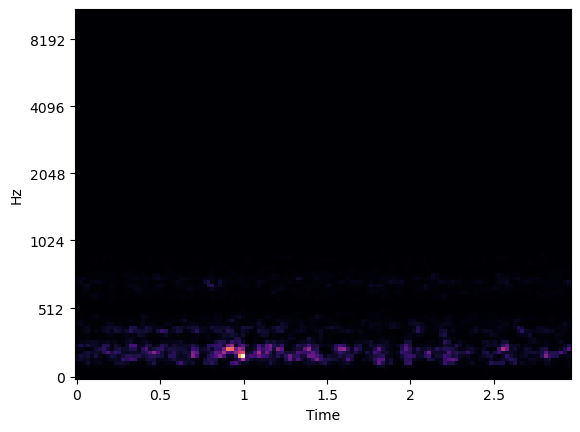

In [24]:
y, sr = librosa.load('fold1/134717-0-0-19.wav', duration = 2.97)
ps = librosa.feature.melspectrogram(y = y, sr = sr)
librosa.display.specshow(ps, y_axis = 'mel', x_axis = 'time');

In [26]:
valid_data['path'] = 'fold' + valid_data['fold'].astype('str') + '/' + valid_data['slice_file_name'].astype('str')

In [28]:
valid_data.sample(5)

,slice_file_name,fold,classID,class,path
6858,57320-0-0-15.wav,1,0,air_conditioner,fold1/57320-0-0-15.wav
8117,79089-0-0-48.wav,9,0,air_conditioner,fold9/79089-0-0-48.wav
7040,61626-9-0-6.wav,4,9,street_music,fold4/61626-9-0-6.wav
8492,94632-5-0-34.wav,6,5,engine_idling,fold6/94632-5-0-34.wav
3228,166942-0-0-1.wav,4,0,air_conditioner,fold4/166942-0-0-1.wav


#### Iterate Over Data 

In [31]:
D = []

for row in valid_data.itertuples():
    y, sr = librosa.load(row.path, duration = 2.97)
    ps = librosa.feature.melspectrogram(y = y, sr = sr)
    if ps.shape != (128, 128):
        continue
    D.append( (ps, row.classID) )

In [32]:
print('Number of Samples: ', len(D))

Number of Samples:  7467


### Split Data

In [34]:
dataset = D
random.shuffle(dataset)

train = dataset[:7000]
test = dataset[7000:]

X_train, y_train = zip(*train)
X_test, y_test = zip(*test)

# Reshape Data
X_train = np.array([x.reshape( (128,128,1) ) for x in X_train])
X_test = np.array([x.reshape( (128,128,1) ) for x in X_test])

In [35]:
# One Hot Encoding of Test classes
y_train = np.array(keras.utils.to_categorical(y_train, 10))
y_test = np.array(keras.utils.to_categorical(y_test, 10))

### Make a Model

In [37]:
model = Sequential()

# Using 24 5*5 kernels
model.add(Conv2D(24, (5,5), strides = (1,1), input_shape = (128, 128, 1)))
model.add(MaxPooling2D((4,2) , strides = (4,2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5,5), strides = (1,1), padding = 'valid'))
model.add(MaxPooling2D((4,2) , strides = (4,2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5,5), strides = (1,1), padding = 'valid'))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate = 0.5))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate = 0.5))

model.add(Dense(10))
model.add(Activation('softmax'))

### Compile the model

In [46]:
model.compile(optimizer = 'adam',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

model.fit(x = X_train,
         y = y_train,
         epochs = 12,
         batch_size = 128,
         validation_data = (X_test, y_test))

score = model.evaluate(x = X_test,
                      y = y_test)

print('Test Loss:', score[0])

Epoch 1/12
55/55 [==============================] - 13s 224ms/step - loss: 1.0839 - accuracy: 0.6297 - val_loss: 1.0255 - val_accuracy: 0.6938
Epoch 2/12
55/55 [==============================] - 11s 196ms/step - loss: 0.9919 - accuracy: 0.6709 - val_loss: 1.0412 - val_accuracy: 0.6574
Epoch 3/12
55/55 [==============================] - 11s 197ms/step - loss: 0.9679 - accuracy: 0.6826 - val_loss: 0.9920 - val_accuracy: 0.7088
Epoch 4/12
55/55 [==============================] - 11s 199ms/step - loss: 0.9036 - accuracy: 0.7047 - val_loss: 1.0463 - val_accuracy: 0.7238
Epoch 5/12
55/55 [==============================] - 11s 198ms/step - loss: 0.8847 - accuracy: 0.7109 - val_loss: 0.8535 - val_accuracy: 0.7495
Epoch 6/12
55/55 [==============================] - 11s 201ms/step - loss: 0.8207 - accuracy: 0.7329 - val_loss: 0.9243 - val_accuracy: 0.7409
Epoch 7/12
55/55 [==============================] - 11s 197ms/step - loss: 0.7676 - accuracy: 0.7573 - val_loss: 1.1762 - val_accuracy: 0.6959

In [ ]:
print('Test Accuracy', score[1])

### Data Augmentation

#### Changing Time of Audio

In [ ]:
import soundfile as sf

In [ ]:
rate = 1.07

for row in valid_data.itertuples():
    y, sr = librosa.load(row.path)
    y_changed = librosa.effects.time_stretch(y, rate = rate)
    sf.write('fold' + str(row.fold) + '/speed_' + str(int(rate*100)) + '/' + row.slice_file_name, y_changed, sr)

#### Changing Pitch of Audio

In [ ]:
n_steps = 2

for row in valid_data.itertuples():
    y, sr = librosa.load(row.path)
    y_changed = librosa.effects.ptch_shift(y, sr, n_steps = n_steps)
    sf.write('fold' + str(row.fold) + '/ps1_' + str(int(n_steps)) + '/' + row.slice_file_name, y_changed, sr)